In [ ]:
#挂载谷歌硬盘
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
#下载coco2017数据集
!wget http://images.cocodataset.org/zips/train2017.zip

--2020-06-26 09:51:35--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.102.59
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.102.59|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip        89%[================>   ]  16.12G  20.9MB/s    eta 48s    

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import zipfile as zf
from PIL import Image
import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from utils import *
from models import *

import numpy as np

from tqdm import tqdm
import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")   #使用GPU训练模型

# 搭建神经网络模型


In [ ]:
! /opt/bin/nvidia-smi

Wed Jun 24 11:27:36 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [ ]:
def ConvLayer(in_channels, out_channels, kernel_size=3, stride=1, 
    upsample=None, instance_norm=True, relu=True):
    layers = []
    if upsample:
        layers.append(nn.Upsample(mode='nearest', scale_factor=upsample))
    layers.append(nn.ReflectionPad2d(kernel_size // 2))
    layers.append(nn.Conv2d(in_channels, out_channels, kernel_size, stride))
    if instance_norm:
        layers.append(nn.InstanceNorm2d(out_channels))
    if relu:
        layers.append(nn.ReLU())
    return layers

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv = nn.Sequential(
            *ConvLayer(channels, channels, kernel_size=3, stride=1), 
            *ConvLayer(channels, channels, kernel_size=3, stride=1, relu=False)
        )

    def forward(self, x):
        return self.conv(x) + x

In [ ]:
class TransformNet(nn.Module):
    def __init__(self, base=32):
        super(TransformNet, self).__init__()
        self.downsampling = nn.Sequential(
            *ConvLayer(3, base, kernel_size=9), 
            *ConvLayer(base, base*2, kernel_size=3, stride=2), 
            *ConvLayer(base*2, base*4, kernel_size=3, stride=2), 
        )
        self.residuals = nn.Sequential(*[ResidualBlock(base*4) for i in range(5)])
        self.upsampling = nn.Sequential(
            *ConvLayer(base*4, base*2, kernel_size=3, upsample=2),
            *ConvLayer(base*2, base, kernel_size=3, upsample=2),
            *ConvLayer(base, 3, kernel_size=9, instance_norm=False, relu=False),
        )
    
    def forward(self, X):
        y = self.downsampling(X)
        y = self.residuals(y)
        y = self.upsampling(y)
        return y

## 解压 COCO 数据集

In [ ]:
files = zf.ZipFile("/content/train2017.zip",'r')
files.extractall()

In [ ]:
!mv /content/train2017 /content/pic/train2017

In [ ]:
batch_size = 4
width = 256

data_transform = transforms.Compose([
    transforms.Resize(width), 
    transforms.CenterCrop(width), 
    transforms.ToTensor(), 
    tensor_normalizer, 
])

dataset = torchvision.datasets.ImageFolder('/content/pic', transform=data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataset

Dataset ImageFolder
    Number of datapoints: 118287
    Root location: /content/pic
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(256, 256))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## 计算Gram矩阵

In [ ]:
style_path = "autumn.png"
style_img = read_image(style_path).to(device)
imshow(style_img, title='Style Image')

In [ ]:
def gram_matrix(y):
    (b, ch, h, w) = y.size()
    features = y.view(b, ch, w * h)
    features_t = features.transpose(1, 2)
    gram = features.bmm(features_t) / (ch * h * w)
    return gram
    
style_features = vgg16(style_img)
style_grams = [gram_matrix(x) for x in style_features]
style_grams = [x.detach() for x in style_grams]
[x.shape for x in style_grams]

[torch.Size([1, 64, 64]),
 torch.Size([1, 128, 128]),
 torch.Size([1, 256, 256]),
 torch.Size([1, 512, 512])]

## 开始训练


In [ ]:
%rm -rf /content/debug

In [ ]:
%mkdir -p debug

def tensor_to_array(tensor):
    x = tensor.cpu().detach().numpy()
    x = (x*255).clip(0, 255).transpose(0, 2, 3, 1).astype(np.uint8)
    return x

def save_debug_image(style_images, content_images, transformed_images, filename):
    style_image = Image.fromarray(recover_image(style_images))
    content_images = [recover_image(x) for x in content_images]
    transformed_images = [recover_image(x) for x in transformed_images]
    
    new_im = Image.new('RGB', (style_image.size[0] + (width + 5) * 4, max(style_image.size[1], width*2 + 5)))
    new_im.paste(style_image, (0,0))
    
    x = style_image.size[0] + 5
    for i, (a, b) in enumerate(zip(content_images, transformed_images)):
        new_im.paste(Image.fromarray(a), (x + (width + 5) * i, 0))
        new_im.paste(Image.fromarray(b), (x + (width + 5) * i, width + 5))
    
    new_im.save(filename)

In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23]).to(device).eval()
transform_net = TransformNet(32).to(device)
torch.cuda.empty_cache()

In [ ]:
verbose_batch = 800
style_weight = 1e5
content_weight = 1
tv_weight = 1e-6

optimizer = optim.Adam(transform_net.parameters(), 1e-3)
transform_net.train()
n_batch = len(data_loader)

for epoch in range(2):
    print('Epoch: {}'.format(epoch+1))
    smooth_content_loss = Smooth()
    smooth_style_loss = Smooth()
    smooth_tv_loss = Smooth()
    smooth_loss = Smooth()
    with tqdm(enumerate(data_loader), total=n_batch) as pbar:
        for batch, (content_images, _) in pbar:
            optimizer.zero_grad()

            # 使用风格模型预测风格迁移图像
            content_images = content_images.to(device)
            transformed_images = transform_net(content_images)
            transformed_images = transformed_images.clamp(-3, 3)

            # 提取特征
            content_features = vgg16(content_images)
            transformed_features = vgg16(transformed_images)

            # 计算内容损失
            content_loss = content_weight * F.mse_loss(transformed_features[1], content_features[1])
            
            # 计算TotalVariation损失
            y = transformed_images
            tv_loss = tv_weight * (torch.sum(torch.abs(y[:, :, :, :-1] - y[:, :, :, 1:])) + 
            torch.sum(torch.abs(y[:, :, :-1, :] - y[:, :, 1:, :])))

            # 计算风格损失
            style_loss = 0.
            transformed_grams = [gram_matrix(x) for x in transformed_features]
            for transformed_gram, style_gram in zip(transformed_grams, style_grams):
                style_loss += style_weight * F.mse_loss(transformed_gram, 
                                                        style_gram.expand_as(transformed_gram))

            # 损失统计
            loss = style_loss + content_loss + tv_loss

            loss.backward()
            optimizer.step()

            smooth_content_loss += content_loss.item()
            smooth_style_loss += style_loss.item()
            smooth_tv_loss += tv_loss.item()
            smooth_loss += loss.item()
            
            s = f'Content: {smooth_content_loss:.2f} '
            s += f'Style: {smooth_style_loss:.2f} '
            s += f'TV: {smooth_tv_loss:.4f} '
            s += f'Loss: {smooth_loss:.2f}'
            #if batch % verbose_batch == 0:
            if batch % verbose_batch == 0:
                s = '\n' + s
                save_debug_image(style_img, content_images, transformed_images, 
                                 f"debug/s2_{epoch}_{batch}.jpg")
            
            pbar.set_description(s)
    torch.save(transform_net.state_dict(), 'transform_net.pth')


  0%|          | 0/29572 [00:00<?, ?it/s]

Epoch: 1



Content: 9.87 Style: 45.77 TV: 0.2494 Loss: 55.89:   0%|          | 0/29572 [00:00<?, ?it/s]
Content: 7.17 Style: 25.54 TV: 0.0596 Loss: 32.77:   3%|▎         | 800/29572 [03:55<2:23:33,  3.34it/s]
Content: 7.20 Style: 25.48 TV: 0.0600 Loss: 32.74:   3%|▎         | 800/29572 [03:56<2:23:33,  3.34it/s]
Content: 7.05 Style: 2.38 TV: 0.3077 Loss: 9.74:   5%|▌         | 1600/29572 [07:53<2:19:41,  3.34it/s]
Content: 7.06 Style: 2.38 TV: 0.3079 Loss: 9.75:   5%|▌         | 1600/29572 [07:53<2:19:41,  3.34it/s]
Content: 6.00 Style: 2.00 TV: 0.3063 Loss: 8.30:   8%|▊         | 2400/29572 [11:51<2:15:18,  3.35it/s]
Content: 6.00 Style: 2.00 TV: 0.3062 Loss: 8.31:   8%|▊         | 2400/29572 [11:51<2:15:18,  3.35it/s]
Content: 4.82 Style: 1.58 TV: 0.2991 Loss: 6.71:  16%|█▌        | 4800/29572 [23:44<2:02:10,  3.38it/s]
Content: 8.89 Style: 45.43 TV: 0.0367 Loss: 54.36:  19%|█▉        | 5600/29572 [27:40<1:57:30,  3.40it/s]
Content: 8.89 Style: 45.29 TV: 0.0367 Loss: 54.21:  19%|█▉        | 56

Epoch: 2



Content: 3.94 Style: 1.44 TV: 0.3053 Loss: 5.68:   0%|          | 0/29572 [00:00<?, ?it/s]
Content: 4.32 Style: 1.57 TV: 0.2929 Loss: 6.18:   3%|▎         | 800/29572 [03:55<2:21:30,  3.39it/s]
Content: 4.32 Style: 1.56 TV: 0.2930 Loss: 6.18:   3%|▎         | 800/29572 [03:55<2:21:30,  3.39it/s]
Content: 4.54 Style: 1.68 TV: 0.2931 Loss: 6.51:   5%|▌         | 1600/29572 [07:50<2:15:52,  3.43it/s]
Content: 4.54 Style: 1.68 TV: 0.2931 Loss: 6.51:   5%|▌         | 1600/29572 [07:50<2:15:52,  3.43it/s]
Content: 4.14 Style: 1.47 TV: 0.2958 Loss: 5.91:   8%|▊         | 2400/29572 [11:44<2:13:20,  3.40it/s]
Content: 4.14 Style: 1.47 TV: 0.2958 Loss: 5.91:   8%|▊         | 2400/29572 [11:45<2:13:20,  3.40it/s]
Content: 4.06 Style: 1.52 TV: 0.2946 Loss: 5.87:  24%|██▍       | 7200/29572 [35:21<1:49:31,  3.40it/s]
Content: 5.49 Style: 4.40 TV: 0.2776 Loss: 10.17:  27%|██▋       | 8000/29572 [39:17<1:46:29,  3.38it/s]
Content: 5.49 Style: 4.35 TV: 0.2780 Loss: 10.12:  27%|██▋       | 8000/29572

# 可视化风格图片

(585, 658, 3)
(600, 900, 3)
(600, 900, 3)


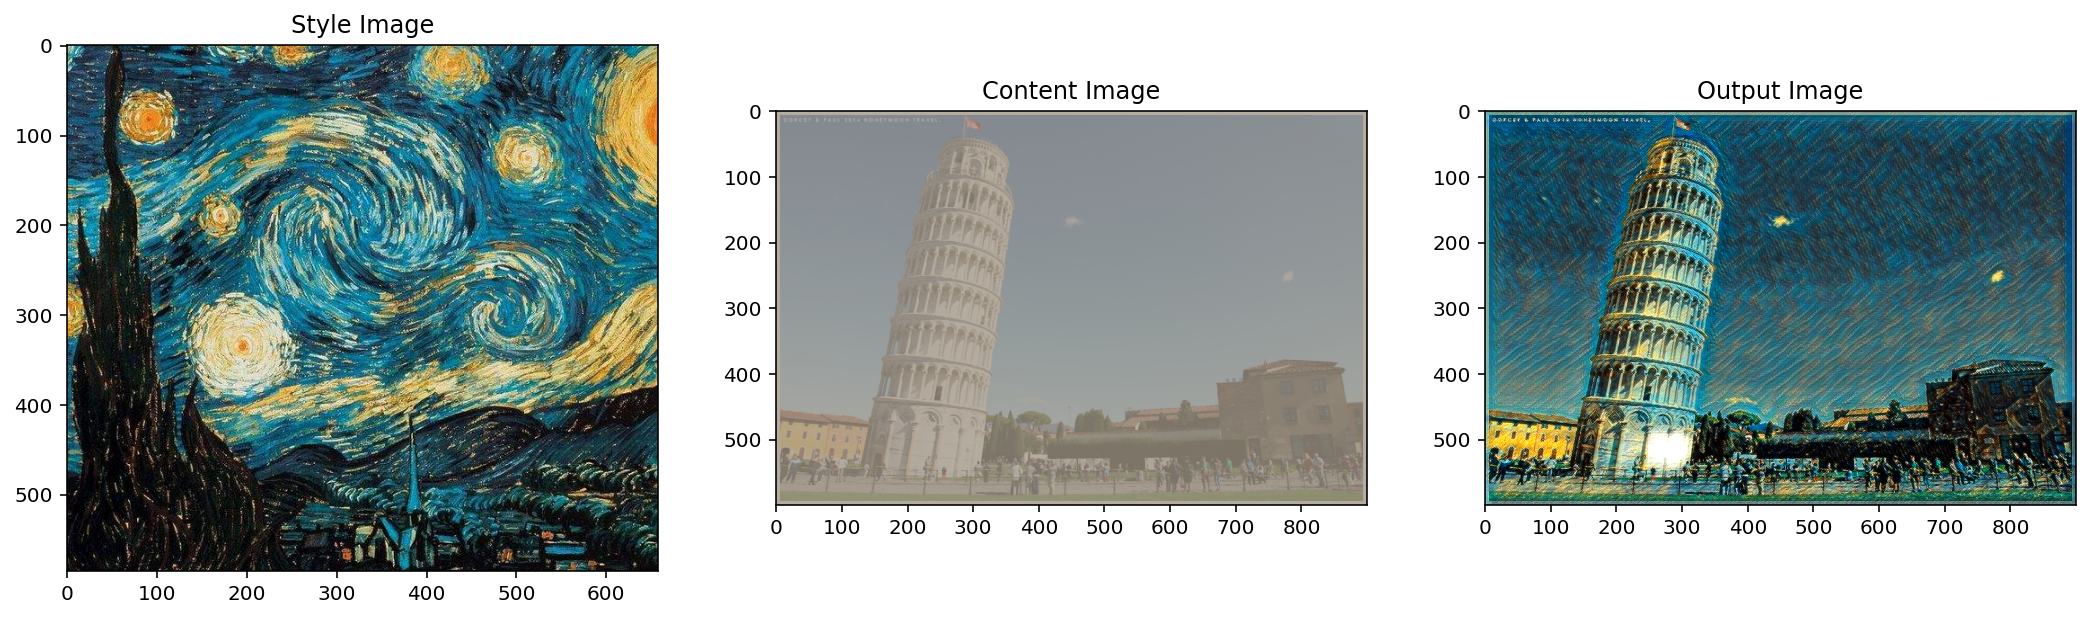

In [ ]:
content_img = random.choice(dataset)[0].unsqueeze(0).to(device)

output_img = transform_net(content_image)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
imshow(style_img, title='Style Image')

plt.subplot(1, 3, 2)
imshow(content_image, title='Content Image')

plt.subplot(1, 3, 3)
imshow(output_img.detach(), title='Output Image')

# 快速图像风格迁移


(650, 648, 3)
(652, 648, 3)


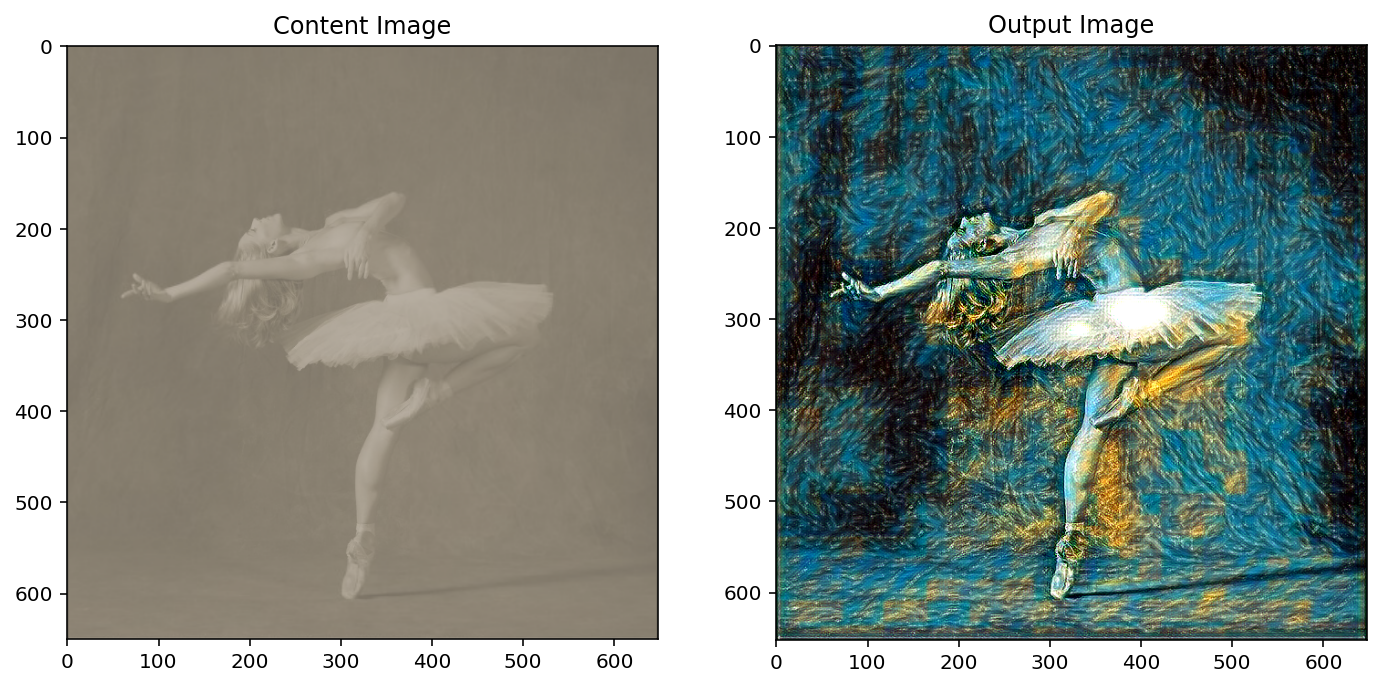

In [ ]:
def Transfer(style_state,transfer_img,output_path):
  transform =TransformNet(32).to(device)
  transform.load_state_dict(torch.load(style_state,map_location=lambda storage, loc: storage))
  transform.eval()

  content_image = torchvision.datasets.folder.default_loader(transfer_img)
  content_transform = torchvision.transforms.Compose([
          torchvision.transforms.ToTensor(),
      ])
  content_image = content_transform(content_image)
  content_image = content_image.unsqueeze(0).to(device)

  output_img = transform(content_image)

  plt.figure(figsize=(18, 6))

  plt.subplot(1, 3, 2)
  imshow(content_image, title='Content Image')

  plt.subplot(1, 3, 3)
  imshow(output_img.detach(), title='Output Image')

  output_data = output_img.cpu().data[0]
  torchvision.utils.save_image(((output_data / 255)).clamp(min=0, max=1), output_path)


# 第一个参数为训练好的模型文件，第二个参数为需要进行风格迁移的图片，第三个参数为输出图片的路径

Transfer('Starry_Night.pth','target2.png','output.jpg')